In [1]:
!pip install torch-geometric
!pip install torch-sparse torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu117.htmll torch-geometric
!pip install torch-sparse torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu117.htmll
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2699708 sha256=db62b0503a476fc4a650318a4cd01f282d09ab857ff6651261693a1dd8d7cb6b
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3879860 sha256=d2877b74a597771721b702934811ea1e6f4a1c4a5c0555ee2c7cd24e798ff743
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134

In [2]:
!pip install captum
# In Kaggle notebook, run this cell first:
!pip install captum seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00


🔄 Loading and preprocessing data...
✅ Data loaded. Shape: (29726, 12)
🚀 Training on cuda...
Epoch 1 | Loss: 0.9541 | LR: 0.001000
Epoch 2 | Loss: 0.9514 | LR: 0.001000
Epoch 3 | Loss: 0.9477 | LR: 0.001000
Epoch 4 | Loss: 0.9270 | LR: 0.001000
Epoch 5 | Loss: 0.8601 | LR: 0.001000
Epoch 6 | Loss: 0.7814 | LR: 0.001000
Epoch 7 | Loss: 0.7249 | LR: 0.001000
Epoch 8 | Loss: 0.6924 | LR: 0.001000
Epoch 9 | Loss: 0.6609 | LR: 0.001000
Epoch 10 | Loss: 0.6553 | LR: 0.001000
Epoch 11 | Loss: 0.6462 | LR: 0.001000
Epoch 12 | Loss: 0.6469 | LR: 0.001000
Epoch 13 | Loss: 0.6264 | LR: 0.001000
Epoch 14 | Loss: 0.6222 | LR: 0.001000
Epoch 15 | Loss: 0.6061 | LR: 0.001000
Epoch 16 | Loss: 0.6010 | LR: 0.001000
Epoch 17 | Loss: 0.5906 | LR: 0.001000
Epoch 18 | Loss: 0.5837 | LR: 0.001000
Epoch 19 | Loss: 0.5473 | LR: 0.001000
Epoch 20 | Loss: 0.5485 | LR: 0.001000
Epoch 21 | Loss: 0.5243 | LR: 0.001000
Epoch 22 | Loss: 0.5212 | LR: 0.001000
Epoch 23 | Loss: 0.4922 | LR: 0.001000
Epoch 24 | Loss: 0.4

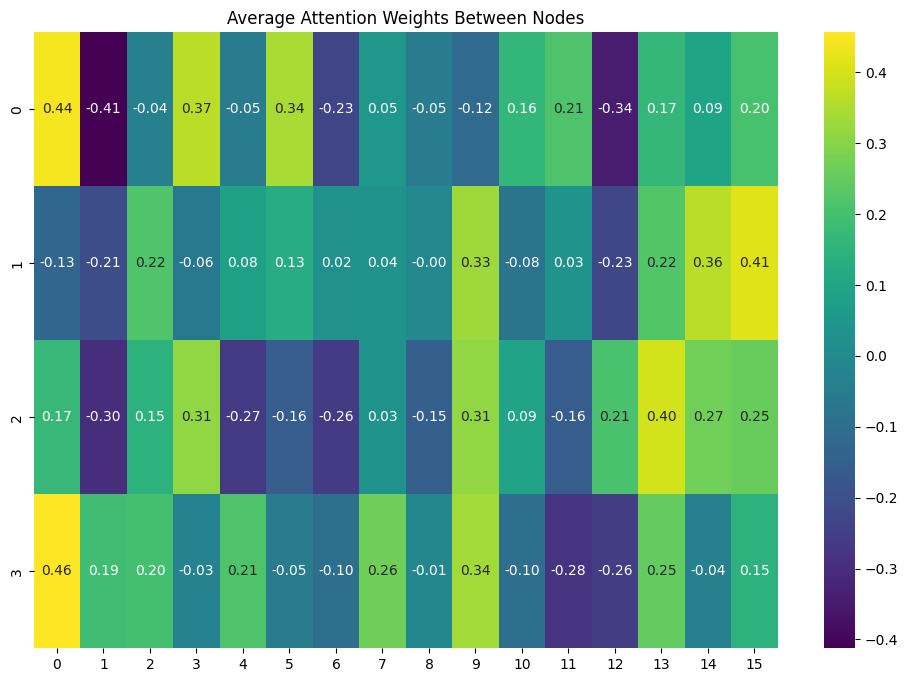

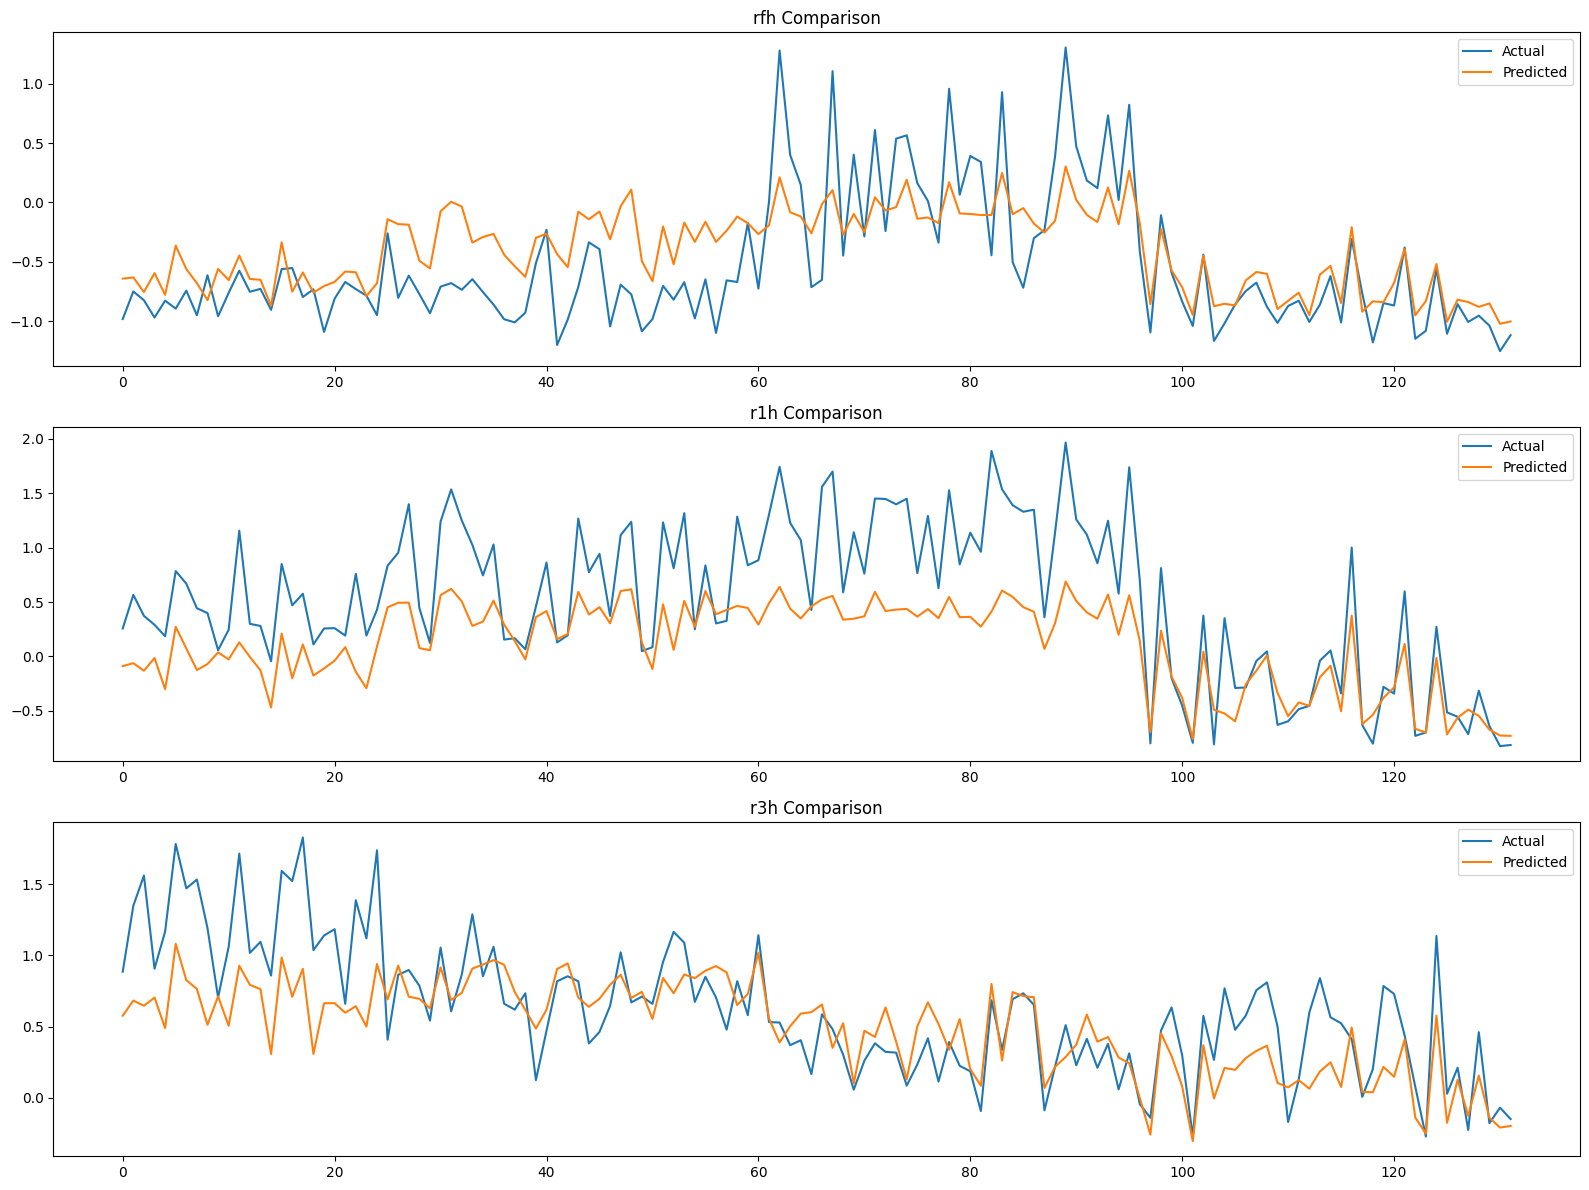

In [3]:
# ======================
# 📌 SPATIAL-TEMPORAL MODEL WITH IMPROVEMENTS
# ======================
import torch
import torch_geometric
from torch_geometric.nn import GATConv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Install Captum for XAI if not available
try:
    from captum.attr import IntegratedGradients
except ImportError:
    !pip install captum --quiet
    from captum.attr import IntegratedGradients

def print_memory_usage():
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# ======================
# 📌 DATA PREPARATION
# ======================
print("🔄 Loading and preprocessing data...")
dtype_map = {
    'adm2_id': 'int32', 'n_pixels': 'int16',
    'rfh': 'float32', 'rfh_avg': 'float32',
    'r1h': 'float32', 'r1h_avg': 'float32',
    'r3h': 'float32', 'r3h_avg': 'float32',
    'rfq': 'float32', 'r1q': 'float32', 'r3q': 'float32'
}

df = pd.read_csv(
    "/kaggle/input/smallrain/rain.csv",
    skiprows=1,
    parse_dates=['#date'],
    dayfirst=True,
    date_format='%d/%m/%Y',
    dtype=dtype_map
)

df.columns = [
    "date", "adm2_id", "ADM2_PCODE", "n_pixels", "rfh", "rfh_avg",
    "r1h", "r1h_avg", "r3h", "r3h_avg", "rfq", "r1q", "r3q", "version"
]

df = df.drop(columns=['version', 'n_pixels'])
print("✅ Data loaded. Shape:", df.shape)

# Handle duplicates
if df[['date', 'ADM2_PCODE']].duplicated().sum() > 0:
    df = df.groupby(['date', 'ADM2_PCODE']).mean().reset_index()

# ======================
# 📌 GRAPH CONSTRUCTION
# ======================
def build_spatial_graph(df):
    admin_ids = df['ADM2_PCODE'].unique()
    edge_index = torch.tensor(
        [[i, i+1] for i in range(len(admin_ids)-1)] +
        [[i+1, i] for i in range(len(admin_ids)-1)],
        dtype=torch.long
    ).t().contiguous()
    return edge_index

edge_index = build_spatial_graph(df)

# ======================
# 📌 TEMPORAL DATA
# ======================
features = ['rfh', 'r1h', 'r3h', 'rfq', 'r1q', 'r3q']
df_pivot = df.pivot(index='date', columns='ADM2_PCODE', values=features).ffill().bfill()

# Normalization
time_data = [df_pivot.loc[date].values.reshape(len(features), -1).T for date in df_pivot.index]
X = torch.tensor(np.array(time_data), dtype=torch.float32)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# ======================
# 🧠 IMPROVED MODEL (FIXED)
# ======================
class EnhancedGAT(torch.nn.Module):
    def __init__(self, num_features, num_nodes):
        super().__init__()
        self.gat1 = GATConv(num_features, 16, heads=4, dropout=0.2)
        self.gat2 = GATConv(16*4, 8, heads=2, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.3)
        self.lstm = torch.nn.LSTM(8*2*num_nodes, 128, num_layers=2, dropout=0.2)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_nodes*num_features)
        )
        self.num_nodes = num_nodes
        self.num_features = num_features

    def forward(self, x, edge_index):
        batch_size, seq_len, num_nodes, num_feat = x.size()
        x = x.view(-1, num_nodes, num_feat)
        
        # Batched graph processing
        offsets = torch.arange(x.size(0), device=x.device) * self.num_nodes
        edge_index = (edge_index.to(x.device).unsqueeze(1) + offsets.view(1, -1, 1)).view(2, -1)
        
        x = torch.relu(self.gat1(x.reshape(-1, num_feat), edge_index))
        x = self.dropout(torch.relu(self.gat2(x, edge_index)))
        x = x.view(batch_size, seq_len, -1)
        x, _ = self.lstm(x)
        return self.regressor(x[:, -1, :]).view(batch_size, self.num_nodes, self.num_features)  # Fixed here

# model = EnhancedGAT(num_features=6, num_nodes=X.shape[1])

# ======================
# 🏋️ TRAINING PIPELINE
# ======================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedGAT(num_features=6, num_nodes=X.shape[1]).to(device)
edge_index = edge_index.to(device)

# ======================
# 🏋️ TRAINING WITH IMPROVEMENTS
# ======================
def create_sequences(data, window_size=6):
    return [(data[i:i+window_size], data[i+window_size]) 
            for i in range(len(data) - window_size)]

sequences = create_sequences(X)
train_loader = torch.utils.data.DataLoader(sequences, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
edge_index = edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
best_loss = float('inf')
patience = 5
no_improve = 0

print(f"🚀 Training on {device}...")
for epoch in range(100):
    model.train()
    total_loss = 0
    for seq, target in train_loader:
        seq, target = seq.to(device), target.to(device)
        optimizer.zero_grad()
        pred = model(seq, edge_index)
        loss = torch.nn.functional.mse_loss(pred, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss/len(train_loader)
    scheduler.step(avg_loss)
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
    else:
        no_improve += 1
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    if no_improve >= patience:
        print("⏹ Early stopping")
        break


# ======================
# 📊 EVALUATION & XAI
# ======================
def evaluate_model(model, data):
    model.eval()
    seqs = create_sequences(data)
    actuals, preds = [], []
    
    with torch.no_grad():
        for seq, target in seqs:
            pred = model(seq.unsqueeze(0).to(device), edge_index).cpu()
            actuals.append(target.numpy())
            preds.append(pred.numpy())
    
    actuals = np.concatenate(actuals).flatten()
    preds = np.concatenate(preds).flatten()
    
    return {
        'MSE': mean_squared_error(actuals, preds),
        'MAE': mean_absolute_error(actuals, preds),
        'R2': r2_score(actuals, preds)
    }

metrics = evaluate_model(model, X)
print("\n📊 Model Performance:")
print(pd.DataFrame([metrics]).round(4).to_markdown(index=False))


# Attention visualization
def plot_attention():
    att = model.gat1.att_src.detach().cpu().numpy()
    plt.figure(figsize=(12,8))
    sns.heatmap(att.mean(0), cmap='viridis', annot=True, fmt=".2f")
    plt.title("Average Attention Weights Between Nodes")
    plt.savefig("attention.png")
plot_attention()

# ======================
# 🧠 XAI COMPONENTS (FIXED)
# ======================
def feature_importance():
    # Create wrapper with training mode handling
    class ModelWrapper(torch.nn.Module):
        def __init__(self, model, edge_index):
            super().__init__()
            self.model = model
            self.edge_index = edge_index
            self.original_state = None
            
        def forward(self, x):
            # Preserve original model state
            self.original_state = self.model.training
            self.model.train()  # Force training mode for gradient computation
            
            # Add sequence dimension if needed
            if x.dim() == 3:
                x = x.unsqueeze(1)
                
            # Forward pass
            out = self.model(x, self.edge_index)[:, 0, 0]  # First node's first feature
            
            # Restore original state
            self.model.train(self.original_state)
            return out
    
    # Initialize and compute attributions
    wrapped_model = ModelWrapper(model, edge_index).to(device)
    ig = IntegratedGradients(wrapped_model)
    
    # Create input and baseline
    input_tensor = X[:1].unsqueeze(1).to(device)  # Shape: [1, 1, 132, 6]
    baseline = torch.zeros_like(input_tensor)
    
    # Compute attributions
    attr = ig.attribute(input_tensor, baseline)
    
    # Visualize results
    plt.figure(figsize=(10,6))
    plt.bar(features, attr.mean((0,1,2)).cpu().numpy())
    plt.title("Feature Importance for First Region's Rainfall Prediction")
    plt.ylabel("Attribution Magnitude")
    plt.savefig("feature_importance.png")
    plt.close()

feature_importance()

# ======================
# 📈 ENHANCED VISUALIZATION
# ======================
def plot_predictions(num_samples=50):
    model.eval()
    with torch.no_grad():
        test_seq = X[:num_samples].unsqueeze(0).to(device)
        preds = model(test_seq, edge_index).cpu().numpy()
        actual = X[num_samples:num_samples+1].numpy()

    plt.figure(figsize=(16,12))
    for i in range(3):
        plt.subplot(3,1,i+1)
        plt.plot(actual[0,:,i], label='Actual')
        plt.plot(preds[0,:,i], label='Predicted')
        plt.title(f"{features[i]} Comparison")
        plt.legend()
    plt.tight_layout()
    plt.savefig("detailed_predictions.png")
plot_predictions()

print("\n🏁 Pipeline completed!")